# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import datetime

import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, first, udf
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.classification import GBTClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler, OneHotEncoder, StringIndexer, OneHotEncoderEstimator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.mllib.util import MLUtils

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set()
colorlist = ["r", "b"]
palette="Pastel1"

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '37207'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.host', '6025eac23b11'),
 ('spark.app.id', 'local-1631020094891'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Sparkify Project')]

In [5]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

In [7]:
df.count()

286500

In [8]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [10]:
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [11]:
df_valid.count()

286500

### userId, sessionId

In [12]:
df_valid.describe("userId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [13]:
df_valid.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [14]:
df_valid.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [15]:
df_valid.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [16]:
df_valid = df_valid.filter(df_valid["userId"] != "")

In [17]:
df_valid.count()

278154

In [18]:
df_valid.select("userId").dropDuplicates().count()

225

In [19]:
df_valid.cache()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

### page

In [20]:
df_valid.select("page").dropDuplicates().sort("page").show(100, truncate=False)

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Logout                   |
|NextSong                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



In [21]:
df_valid_page_pd = df_valid.select("page").toPandas()

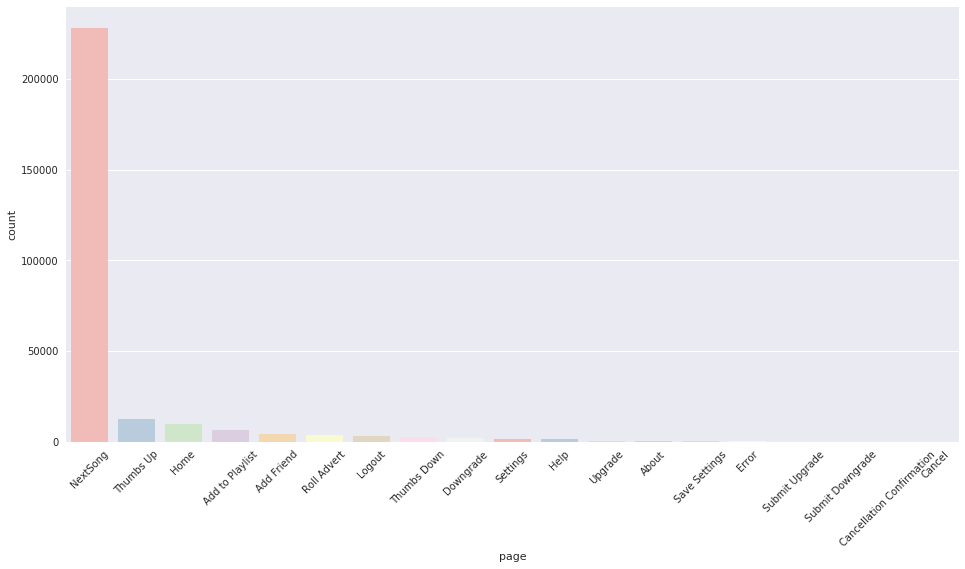

In [22]:
fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation=45)
sns.countplot(x="page", data=df_valid_page_pd, order=df_valid_page_pd["page"].value_counts().index, palette=palette)

In [23]:
df_valid_page_pd_without_NextSong = df_valid_page_pd[df_valid_page_pd.page != "NextSong"]

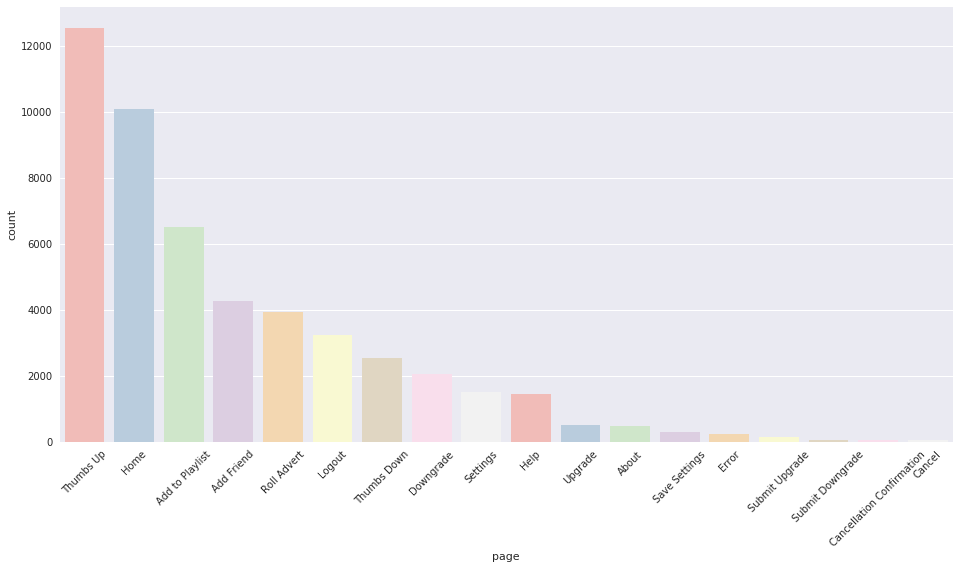

In [24]:
fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation=45)
sns.countplot(x='page', data=df_valid_page_pd_without_NextSong, order=df_valid_page_pd_without_NextSong["page"].value_counts().index, palette=palette)

### level

In [25]:
df_valid.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



### status

In [26]:
# HTTP response status code
df_valid.select("status").dropDuplicates().sort("status").show()

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



### length

In [27]:
# length of time
df_valid.describe("length").show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [25]:
df_valid.filter("page = 'Cancellation Confirmation'").show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

userId = 18: paid -> withdrawn user

In [26]:
df_valid.select(["userId", "firstname", "page", "level", "song"]).where(df_valid.userId == "18").collect()

[Row(userId='18', firstname='Adriel', page='Home', level='paid', song=None),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='A Beggar On A Beach Of Gold'),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='...slowdance On The Inside (Album Version)'),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='St. Apollonia'),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='Drunk Stripper'),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='In League With Satan'),
 Row(userId='18', firstname='Adriel', page='Settings', level='paid', song=None),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='The Quest'),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='Waking The Demon'),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='Why Do You Let Me Stay Here?'),
 Row(userId='18', firstname='Adriel', pag

userId = 32: free -> paid -> withdrawn user

In [27]:
df_valid.select(["userId", "firstname", "page", "level", "song"]).where(df_valid.userId == "32").collect()

[Row(userId='32', firstname='Diego', page='NextSong', level='free', song='Beyond The Beyond (Instrumental)'),
 Row(userId='32', firstname='Diego', page='NextSong', level='free', song='Paradise City'),
 Row(userId='32', firstname='Diego', page='NextSong', level='free', song='Alejandro'),
 Row(userId='32', firstname='Diego', page='Roll Advert', level='free', song=None),
 Row(userId='32', firstname='Diego', page='NextSong', level='free', song='Luv U Better'),
 Row(userId='32', firstname='Diego', page='Thumbs Up', level='free', song=None),
 Row(userId='32', firstname='Diego', page='NextSong', level='free', song='My Life Would Suck Without You'),
 Row(userId='32', firstname='Diego', page='Add to Playlist', level='free', song=None),
 Row(userId='32', firstname='Diego', page='NextSong', level='free', song='Jamaica Roots II(Agora E Sempre)'),
 Row(userId='32', firstname='Diego', page='NextSong', level='free', song='Dusk'),
 Row(userId='32', firstname='Diego', page='NextSong', level='free', son

userId = 125: free -> withdrawn user

In [28]:
df_valid.select(["userId", "firstname", "page", "level", "song"]).where(df_valid.userId == "125").collect()

[Row(userId='125', firstname='Mason', page='NextSong', level='free', song='paranoid android'),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', song='Hypnotize(Album Version)'),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', song="I'm On My Way"),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', song='Leader Of Men (Album Version)'),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', song='Love You Down'),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', song="Don't Leave Me Behind"),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', song="They're Red Hot"),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', song='Kota'),
 Row(userId='125', firstname='Mason', page='Roll Advert', level='free', song=None),
 Row(userId='125', firstname='Mason', page='Cancel', level='free', song=None),
 Row(userId='125', firstname='Mason', page='Cancellation Confirmation'

In [29]:
df_valid.filter("page = 'Submit Downgrade'").show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|     Kael|     M|           47|   Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|
|  null|Logged In|   Calvin|     M|           17|Marshall|  null| paid|      Pittsburgh, PA|   PUT|Submit Downgrade|1537120757000|      313|null|   307|1538516445000|"Mozilla/5.0 (Mac...|    38|
|  null|Logged In|  Kayle

userId = 131: free -> paid -> ...

In [30]:
df_valid.select(["userId", "firstname", "page", "level", "song"]).where(df_valid.userId == "131").collect()

[Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Fade To Black'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Nothingman (Live)'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Fuck Kitty'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Half The Truth'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='(You Make Me Feel Like A) Natural Woman'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Feel The Beat'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Luno'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Angie Baby'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Robot Soul (Radio Edit)'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free', song='Without Me'),
 Row(userId='131', firstname='Kael', page='NextSong', level='free',

In [31]:
df_valid.select(["userId", "firstname", "page", "level", "song"]).where(df_valid.userId == "38").collect()

[Row(userId='38', firstname='Calvin', page='NextSong', level='paid', song='Rattlechaser'),
 Row(userId='38', firstname='Calvin', page='NextSong', level='paid', song='Fader'),
 Row(userId='38', firstname='Calvin', page='NextSong', level='paid', song='Never Gonna Be Alone (Album Version)'),
 Row(userId='38', firstname='Calvin', page='NextSong', level='paid', song='Hilarious Movie Of The 90s'),
 Row(userId='38', firstname='Calvin', page='NextSong', level='paid', song="You're A Big Girl Now"),
 Row(userId='38', firstname='Calvin', page='NextSong', level='paid', song='Invalid'),
 Row(userId='38', firstname='Calvin', page='NextSong', level='paid', song='Chapter II: The Final Victory'),
 Row(userId='38', firstname='Calvin', page='NextSong', level='paid', song='Llorare'),
 Row(userId='38', firstname='Calvin', page='NextSong', level='paid', song='Te Quiero'),
 Row(userId='38', firstname='Calvin', page='NextSong', level='paid', song='Galaxy'),
 Row(userId='38', firstname='Calvin', page='NextSong

In [32]:
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" or x == "Submit Downgrade" else 0, IntegerType())

In [33]:
df_valid = df_valid.withColumn("Churn", flag_churn_event("page"))

In [34]:
# Mark users who have Churn event. userChurned will be the label in model building stage.
df_valid = df_valid.withColumn('userChurned', fmax('Churn').over(Window.partitionBy('userId')))

In [35]:
df_valid.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|userChurned|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----------+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|   NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|    0|          0|
|Francesca Battist...|Logged In|

In [36]:
df_valid.select(["userId", "firstname", "page", "level", "song", "Churn", "userChurned"]).where(df_valid.userId == "18").collect()

[Row(userId='18', firstname='Adriel', page='Home', level='paid', song=None, Churn=0, userChurned=1),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='A Beggar On A Beach Of Gold', Churn=0, userChurned=1),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='...slowdance On The Inside (Album Version)', Churn=0, userChurned=1),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='St. Apollonia', Churn=0, userChurned=1),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='Drunk Stripper', Churn=0, userChurned=1),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='In League With Satan', Churn=0, userChurned=1),
 Row(userId='18', firstname='Adriel', page='Settings', level='paid', song=None, Churn=0, userChurned=1),
 Row(userId='18', firstname='Adriel', page='NextSong', level='paid', song='The Quest', Churn=0, userChurned=1),
 Row(userId='18', firstname='Adriel', page='NextSon

### Users who Stayed vs Users who Churned

In [37]:
df_churn_event = df_valid.where(df_valid.Churn == "1")

In [38]:
df_churn_event.count()

115

In [39]:
users_who_churned = [x[0] for x in df_churn_event.select("userId").dropDuplicates().sort("userId").collect()]

In [40]:
df_churned = df_valid.where(df_valid.userId.isin(users_who_churned))

In [41]:
df_stayed = df_valid.where(~df_valid.userId.isin(users_who_churned))

Number of events: 140415 (df_churned) + 137739 (df_stayed) = 278154 (df_valid)

In [42]:
df_churned.count()

140415

In [43]:
df_stayed.count()

137739

Unique users: 92 (df_churned) + 133 (df_stayed) = 225 (df_valid)

In [44]:
df_churned.select("userId").dropDuplicates().count()

92

In [45]:
df_stayed.select("userId").dropDuplicates().count()

133

#### page

- RollAdvert, ThumbsDown can have impact

In [46]:
df_valid.select(["userChurned", "page"]).groupby(["userChurned", "page"]).count().sort("page").show(100, truncate=False)

+-----------+-------------------------+------+
|userChurned|page                     |count |
+-----------+-------------------------+------+
|0          |About                    |248   |
|1          |About                    |247   |
|1          |Add Friend               |2115  |
|0          |Add Friend               |2162  |
|1          |Add to Playlist          |3296  |
|0          |Add to Playlist          |3230  |
|1          |Cancel                   |52    |
|1          |Cancellation Confirmation|52    |
|1          |Downgrade                |1065  |
|0          |Downgrade                |990   |
|0          |Error                    |140   |
|1          |Error                    |112   |
|1          |Help                     |738   |
|0          |Help                     |716   |
|0          |Home                     |4959  |
|1          |Home                     |5123  |
|0          |Logout                   |1562  |
|1          |Logout                   |1664  |
|0          |

In [47]:
df_page_pd = df_valid.select(["userChurned", "page"]).groupby(["userChurned", "page"]).count().sort("page").toPandas()

In [48]:
df_page_pd.head()

,userChurned,page,count
0,0,About,248
1,1,About,247
2,0,Add Friend,2162
3,1,Add Friend,2115
4,0,Add to Playlist,3230


In [49]:
def normalize_data(df_original):
    """Normalize count for userChurned=0 and 1 each.

    Args:
        df_original (pd.DataFrame): Assumes three columns, first one is 'userChurned' label, 
            second one is a feature in question (e.x. 'page') and the last one is 'count'.

    Returns:
        pd.DataFrame: DataFrame with normalized count for userChurned=0 and 1 each.
    """

    # Get first two columns (i.e. except 'count') as unique index
    groupby_series = df_original.set_index(list(df_original.columns[:2]))

    #  Expand 'userChurned' to the row direction
    tmp = groupby_series.unstack('userChurned').fillna(0)

    # Normalize and reset index
    df = pd.DataFrame(((tmp - tmp.min()) / (tmp.max() - tmp.min())).stack()).reset_index()

    # Rename 'count' column as 'result'
    df = df.rename(columns={df.columns[-1]: 'result'})

    return df

In [50]:
df_page_pd = normalize_data(df_page_pd)

In [51]:
df_page_pd.head()

,page,userChurned,result
0,About,0,0.002184
1,About,1,0.001703
2,Add Friend,0,0.019038
3,Add Friend,1,0.018019
4,Add to Playlist,0,0.028442


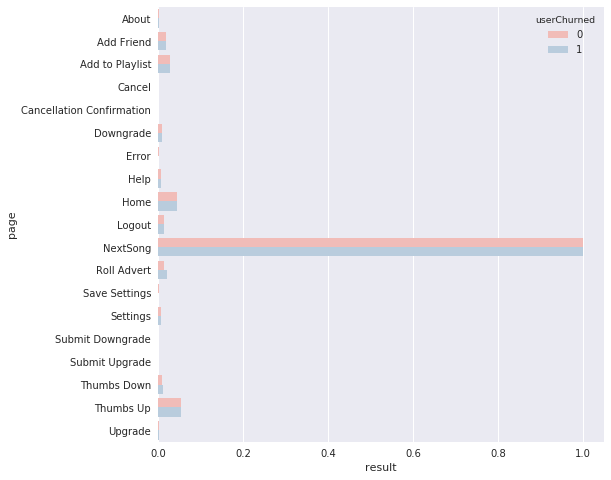

In [52]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x="result", y="page", hue="userChurned", data=df_page_pd, palette=palette, ax=ax)

#### specific action they experienced per a certain time unit

In [53]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [54]:
df_valid = df_valid.withColumn('hour', get_hour(df_valid.ts))
df_valid = df_valid.withColumn('day', get_day(df_valid.ts))
df_valid = df_valid.withColumn('dayofweek', get_weekday(df_valid.ts))

In [55]:
df_hour_pd      = df_valid.select(["userChurned", "hour"]).groupby(["userChurned", "hour"]).count().sort("hour").toPandas()
df_day_pd       = df_valid.select(["userChurned", "day"]).groupby(["userChurned", "day"]).count().sort("day").toPandas()
df_dayofweek_pd = df_valid.select(["userChurned", "dayofweek"]).groupby(["userChurned", "dayofweek"]).count().sort("dayofweek").toPandas()

##### hour

- user who churned: less action during day time?

In [56]:
df_hour_pd = normalize_data(df_hour_pd)

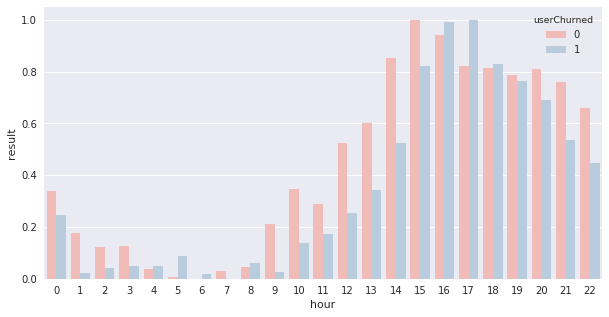

In [57]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x="hour", y="result", hue="userChurned", data=df_hour_pd, palette=palette, ax=ax, order=list(map(lambda x: str(x), range(23))))


##### day

- user who churned: less activity in the latter half of the month?

In [58]:
df_day_pd = normalize_data(df_day_pd)

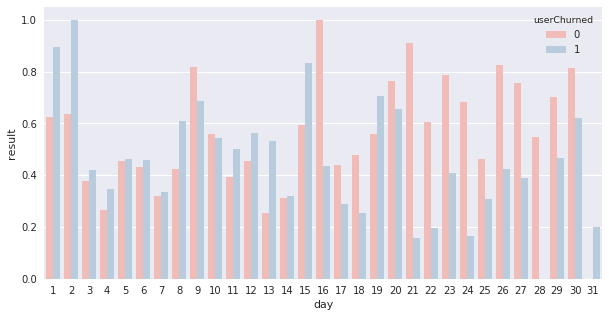

In [59]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x="day", y="result", hue="userChurned", data=df_day_pd, palette=palette, ax=ax, order=list(map(lambda x: str(x), range(1,32))))


##### day of week

- Weekday as a decimal number, where 0 is Sunday and 6 is Saturday.
- user who churned: significantly more activities on Monday (1), Thursday (4), and Saturday (6)

In [60]:
df_dayofweek_pd = normalize_data(df_dayofweek_pd)

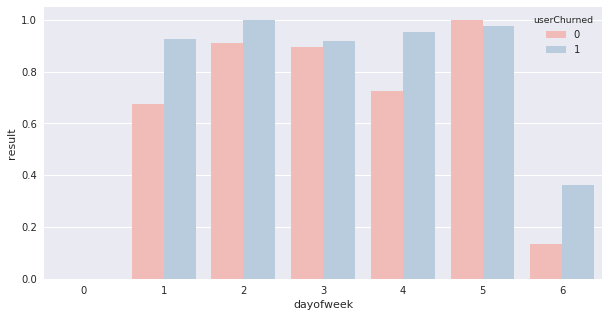

In [61]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x="dayofweek", y="result", hue="userChurned", data=df_dayofweek_pd, palette=palette, ax=ax)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [62]:
# for small dataset
print((df_valid.count(), len(df_valid.columns)))

(278154, 23)


Candidate features

- Gender
- RollAdvert, ThumbsDown can have impact
- less action during day time
- less activity in the latter half of the month
- Monday (1), Thursday (4), and Saturday (6)


In [63]:
def get_features_labels(df):
    """Generate features as pyspark.sql.DataFrame

    Args:
        df (pyspark.sql.DataFrame): DataFrame of user event log with valid userId.

    Returns:
        pyspark.sql.DataFrame: DataFrame with generated features for churn prediction.
    """

    # "Gender"
    feature_gender = df.dropDuplicates(["userId"]).select(["userId", "gender"])

    # "RollAdvert, ThumbsDown can have impact"
    page_count = df.select(["userId", "page"]).groupby(["userId", "page"]).count()
    # create the pivot table
    pivot_table = page_count.groupby("userId").pivot("page").agg(first("count")).fillna(0)
    # filter columns
    pivot_table = pivot_table.select(["userId", "Roll Advert", "Thumbs Down"])
    # column names used to sum up for total
    cols = pivot_table.columns[1:]
    # calculate the total 
    feature_page = pivot_table.withColumn("total", sum([col(c) for c in cols]))


    # "less action during day time"
    hour_count = df.filter((df.hour >= 9) & (df.hour <= 15)).select(["userId"]).groupby(["userId"]).count()
    hour_count = hour_count.selectExpr("userId as userId", "count as hour_count")

    # "less activity in the latter half of the month"
    day_count = df.filter(df.day >= 15).select(["userId"]).groupby(["userId"]).count()
    day_count = day_count.selectExpr("userId as userId", "count as day_count")
    
    total_count = df.select(["userId"]).groupby(["userId"]).count()
    total_count = total_count.selectExpr("userId as userId", "count as total_count")

    #  Monday (1), Thursday (4), and Saturday (6)
    mon_thu_sat_count = df.filter((df.dayofweek == 1) | (df.dayofweek == 4) | (df.dayofweek == 6)).select(["userId"]).groupby(["userId"]).count()
    mon_thu_sat_count = mon_thu_sat_count.selectExpr("userId as userId", "count as mon_thu_sat_count")

    feature_percentage_daytime = (total_count.alias("total").join(hour_count.alias("hour"), ["userId"]).\
                                     select(col("userId"), (col("hour.hour_count") / col("total.total_count")).alias("daytime_percentage")))

    feature_percentage_month = (total_count.alias("total").join(day_count.alias("day"), ["userId"]).\
                                   select(col("userId"), (col("day.day_count") / col("total.total_count")).alias("month_percentage")))

    feature_percentage_mon_thu_sat = (total_count.alias("total").join(mon_thu_sat_count.alias("mon_thu_sat"), ["userId"]).\
                                   select(col("userId"), (col("mon_thu_sat.mon_thu_sat_count") / col("total.total_count")).alias("mon_thu_sat_percentage")))

    # label
    label = df.select(["userId", "userChurned"]).dropDuplicates()

    result = feature_gender.join(feature_page, on="userId", how="inner").\
                            join(feature_percentage_daytime, on="userId", how="inner").\
                            join(feature_percentage_month, on="userId", how="inner").\
                            join(feature_percentage_mon_thu_sat, on="userId", how="inner").\
                            join(label, on="userId", how="inner")

    return result

In [64]:
df_features_labels = get_features_labels(df_valid)

In [65]:
df_features_labels = df_features_labels.withColumn("Roll Advert", df_features_labels["Roll Advert"].cast(IntegerType()))
df_features_labels = df_features_labels.withColumn("Thumbs Down", df_features_labels["Thumbs Down"].cast(IntegerType()))
df_features_labels = df_features_labels.withColumn("total", df_features_labels["total"].cast(IntegerType()))

df_features_labels = df_features_labels.withColumn("daytime_percentage", df_features_labels["daytime_percentage"].cast(FloatType()))
df_features_labels = df_features_labels.withColumn("month_percentage", df_features_labels["month_percentage"].cast(FloatType()))
df_features_labels = df_features_labels.withColumn("mon_thu_sat_percentage", df_features_labels["mon_thu_sat_percentage"].cast(FloatType()))

In [66]:
df_features_labels.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- Roll Advert: integer (nullable = true)
 |-- Thumbs Down: integer (nullable = true)
 |-- total: integer (nullable = true)
 |-- daytime_percentage: float (nullable = true)
 |-- month_percentage: float (nullable = true)
 |-- mon_thu_sat_percentage: float (nullable = true)
 |-- userChurned: integer (nullable = true)



In [67]:
df_features_labels.show()

+------+------+-----------+-----------+-----+------------------+----------------+----------------------+-----------+
|userId|gender|Roll Advert|Thumbs Down|total|daytime_percentage|month_percentage|mon_thu_sat_percentage|userChurned|
+------+------+-----------+-----------+-----+------------------+----------------+----------------------+-----------+
|100010|     F|         52|          5|   57|         0.5223097|       0.4120735|            0.47506562|          0|
|200002|     M|          7|          6|   13|        0.29113925|       0.9219409|            0.79746836|          0|
|   124|     F|          4|         41|   45|        0.27274612|      0.45782384|             0.3693264|          0|
|    51|     M|          0|         21|   21|        0.24066558|      0.16720779|            0.39529222|          1|
|     7|     M|         16|          1|   17|         0.2885572|      0.74129355|            0.03482587|          0|
|    15|     M|          1|         14|   15|        0.32528535|

In [68]:
df_features_labels.count()

199

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [69]:
# Split the dataset into train, test, and validation sets
seed = 42
df_train, df_validation, df_test = df_features_labels.randomSplit([0.6, 0.2, 0.2], seed = seed)

In [70]:
print(df_train.count())

121


In [71]:
df_train.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- Roll Advert: integer (nullable = true)
 |-- Thumbs Down: integer (nullable = true)
 |-- total: integer (nullable = true)
 |-- daytime_percentage: float (nullable = true)
 |-- month_percentage: float (nullable = true)
 |-- mon_thu_sat_percentage: float (nullable = true)
 |-- userChurned: integer (nullable = true)



In [72]:
print(df_validation.count())

45


In [73]:
print(df_test.count())

33


In [74]:
stringIndexerGender = StringIndexer(inputCol="gender", outputCol="genderIndex", handleInvalid="skip")

# OneHotEncoder(Estimator)
# https://spark.apache.org/docs/3.0.0-preview/ml-migration-guide.html#breaking-changes
# "OneHotEncoder which is deprecated in 2.3, is removed in 3.0 and OneHotEncoderEstimator is now renamed to OneHotEncoder."
encoder = OneHotEncoderEstimator(inputCols=["genderIndex"], outputCols=["genderVec"], handleInvalid="keep")

# Scale numerical features: Roll Advert, Thumbs Down, total
assemblerNumerical = VectorAssembler(inputCols=["Roll Advert", "Thumbs Down", "total"], outputCol="NumericalFeatures")
scalerNumerical = StandardScaler(inputCol="NumericalFeatures", outputCol="NumericalFeaturesStandard", withMean=True, withStd=True)

features = ["genderVec", "NumericalFeaturesStandard", "daytime_percentage", "month_percentage", "mon_thu_sat_percentage"]
assembler = VectorAssembler(inputCols=features, outputCol="features")

Test out several machine learning methods

- Random Forest Classifier
- Logistic Regression Classifier
- Gradient-Boosted Tree Classifier
- Decision Tree Classifier

## Random Forest Classifier

In [75]:
# initialize random forest classifier
clf_rf = RandomForestClassifier(labelCol="userChurned", featuresCol="features", numTrees=10)

pipeline_rf = Pipeline(stages = [
    stringIndexerGender, encoder, assemblerNumerical, scalerNumerical, assembler, clf_rf
])

In [76]:
# https://stackoverflow.com/a/66436904
model_rf = pipeline_rf.fit(df_train)

In [77]:
pred_rf_train = model_rf.transform(df_train)
pred_rf_test = model_rf.transform(df_test)

In [78]:
pred_rf_train.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- Roll Advert: integer (nullable = true)
 |-- Thumbs Down: integer (nullable = true)
 |-- total: integer (nullable = true)
 |-- daytime_percentage: float (nullable = true)
 |-- month_percentage: float (nullable = true)
 |-- mon_thu_sat_percentage: float (nullable = true)
 |-- userChurned: integer (nullable = true)
 |-- genderIndex: double (nullable = false)
 |-- genderVec: vector (nullable = true)
 |-- NumericalFeatures: vector (nullable = true)
 |-- NumericalFeaturesStandard: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [79]:
pred_rf_train.show(3)

+------+------+-----------+-----------+-----+------------------+----------------+----------------------+-----------+-----------+-------------+-----------------+-------------------------+--------------------+--------------------+--------------------+----------+
|userId|gender|Roll Advert|Thumbs Down|total|daytime_percentage|month_percentage|mon_thu_sat_percentage|userChurned|genderIndex|    genderVec|NumericalFeatures|NumericalFeaturesStandard|            features|       rawPrediction|         probability|prediction|
+------+------+-----------+-----------+-----+------------------+----------------+----------------------+-----------+-----------+-------------+-----------------+-------------------------+--------------------+--------------------+--------------------+----------+
|   124|     F|          4|         41|   45|        0.27274612|      0.45782384|             0.3693264|          0|        1.0|(2,[1],[1.0])|  [4.0,41.0,45.0]|     [-0.6739100635260...|[0.0,1.0,-0.67391...|[7.6813280

### test F1 score

In [80]:
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="userChurned", predictionCol="prediction")

In [81]:
evaluatorMulti.evaluate(pred_rf_test.select("userChurned", "prediction"), {evaluatorMulti.metricName: "f1"})

0.6900826446280991

## Logistic Regression Classifier

In [82]:
# initialize logistic regression classifier
clf_lr = LogisticRegression(labelCol="userChurned", featuresCol="features", maxIter=100, regParam=0.0, family="auto")

pipeline_lr = Pipeline(stages = [
    stringIndexerGender, encoder, assemblerNumerical, scalerNumerical, assembler, clf_lr
])

In [83]:
# https://stackoverflow.com/a/66436904
model_lr = pipeline_lr.fit(df_train)

In [84]:
pred_lr_train = model_lr.transform(df_train)
pred_lr_test = model_lr.transform(df_test)

### test F1 score

In [85]:
evaluatorMulti.evaluate(pred_lr_test.select("userChurned", "prediction"), {evaluatorMulti.metricName: "f1"})

0.7168831168831169

## Gradient-Boosted Tree Classifier

In [86]:
# initialize gradient-boosted tree classifier
clf_gbt = GBTClassifier(labelCol="userChurned", featuresCol="features")

pipeline_gbt = Pipeline(stages = [
    stringIndexerGender, encoder, assemblerNumerical, scalerNumerical, assembler, clf_gbt
])

In [87]:
# https://stackoverflow.com/a/66436904
model_gbt = pipeline_gbt.fit(df_train)

In [88]:
pred_gbt_train = model_gbt.transform(df_train)
pred_gbt_test = model_gbt.transform(df_test)

### test F1 score

In [89]:
evaluatorMulti.evaluate(pred_gbt_test.select("userChurned", "prediction"), {evaluatorMulti.metricName: "f1"})

0.6632962588473205

## Decision Tree Classifier

In [90]:
# initialize decision tree classifier
clf_dt = DecisionTreeClassifier(labelCol="userChurned", featuresCol="features")

pipeline_dt = Pipeline(stages = [
    stringIndexerGender, encoder, assemblerNumerical, scalerNumerical, assembler, clf_dt
])

In [91]:
# https://stackoverflow.com/a/66436904
model_dt = pipeline_dt.fit(df_train)

In [92]:
pred_dt_train = model_dt.transform(df_train)
pred_dt_test = model_dt.transform(df_test)

### test F1 score

In [93]:
evaluatorMulti.evaluate(pred_dt_test.select("userChurned", "prediction"), {evaluatorMulti.metricName: "f1"})

0.591053391053391

## Parameter tuning for promising model(s)

### Random Forest Classifier

In [98]:
paramGrid_rf = ParamGridBuilder()\
    .addGrid(clf_rf.numTrees, [10, 100]) \
    .addGrid(clf_rf.maxDepth, [3, 7]) \
    .build()

In [99]:
# https://spark.apache.org/docs/2.4.3/ml-tuning.html
crossval_rf = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=evaluatorMulti,
                          numFolds=3)

In [100]:
# Run cross-validation, and choose the best set of parameters.
cvModel_rf = crossval_rf.fit(df_train)

In [101]:
bestModel_rf = cvModel_rf.bestModel

In [102]:
# https://stackoverflow.com/a/55971353
bestModel_rf_param_dict = {k.name: v for k, v in bestModel_rf.stages[-1].extractParamMap().items()}
print(f'numTrees chosen from best model: {bestModel_rf_param_dict["numTrees"]}')
print(f'maxDepth chosen from best model: {bestModel_rf_param_dict["maxDepth"]}')

numTrees chosen from best model: 10
maxDepth chosen from best model: 7


In [103]:
pred_best_rf_test = bestModel_rf.transform(df_test)

In [104]:
evaluatorMulti.evaluate(pred_best_rf_test.select("userChurned", "prediction"), {evaluatorMulti.metricName: "f1"})

0.7245151208750804

### Logistic Regression Classifier

In [108]:
paramGrid_lr = ParamGridBuilder()\
    .addGrid(clf_lr.maxIter, [10, 100]) \
    .addGrid(clf_lr.regParam, [0.0, 0.1]) \
    .build()

In [109]:
# https://spark.apache.org/docs/2.4.3/ml-tuning.html
crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=evaluatorMulti,
                          numFolds=3)

In [110]:
# Run cross-validation, and choose the best set of parameters.
cvModel_lr = crossval_lr.fit(df_train)

In [111]:
# https://stackoverflow.com/a/55971353
bestModel_lr_param_dict = {k.name: v for k, v in cvModel_lr.bestModel.stages[-1].extractParamMap().items()}
print(f'maxIter chosen from best model: {bestModel_lr_param_dict["maxIter"]}')
print(f'regParam chosen from best model: {bestModel_lr_param_dict["regParam"]}')

maxIter chosen from best model: 10
regParam chosen from best model: 0.1


In [112]:
pred_best_lr_test = cvModel_lr.bestModel.transform(df_test)

In [113]:
evaluatorMulti.evaluate(pred_best_lr_test.select("userChurned", "prediction"), {evaluatorMulti.metricName: "f1"})

0.771251145271302

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.